<a href="https://colab.research.google.com/github/yaohualiu/notebook/blob/master/Inverted_Geometry_Neutron_Spectrometer_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

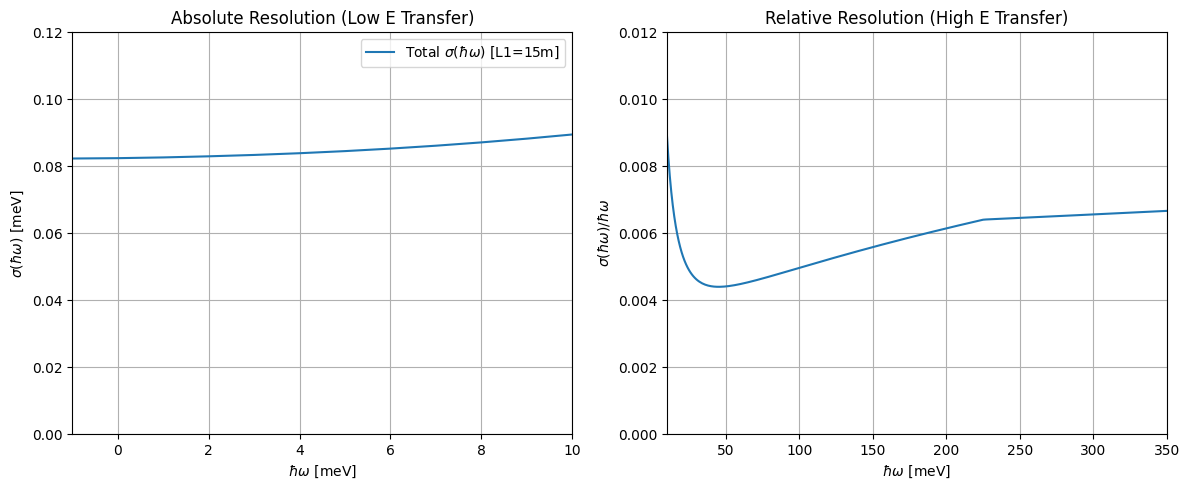

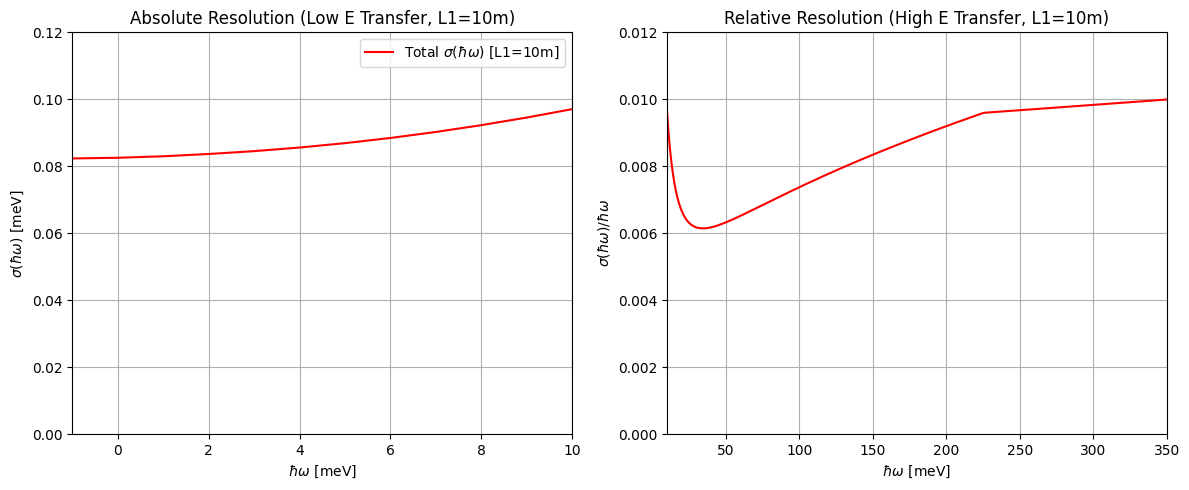

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class InvertedGeometrySpectrometer:
    """
    Calculates the energy resolution of an inverted geometry neutron spectrometer.

    Based on the formulation in the VISION 2009 paper (Eq. 21) and the
    provided Jupyter notebook.
    """
    def __init__(self,
                 L1_m,
                 Z2_m,
                 theta_analyzer_deg=45.0,
                 d_crystal_A=3.348,
                 std_L1_m=5.4e-3,
                 thickness_A_m=2.0e-3,
                 std_B_m=0.7e-3,
                 thickness_C_m=3.0e-3,
                 std_R2_m=11.6e-3):
        """
        Initializes the spectrometer with its parameters and uncertainties.

        Args:
            L1_m (float): Nominal incident flight path (moderator to sample) in meters.
            Z2_m (float): Nominal axial displacement from sample/detector to analyzer
                          crystal in meters.
            theta_analyzer_deg (float, optional): Nominal angle of incidence at the
                                                 analyzer in degrees. Defaults to 45.0.
            d_crystal_A (float, optional): Analyzer crystal plane d-spacing in Angstroms.
                                          Defaults to 3.348 A (PG002).
            std_L1_m (float, optional): Standard deviation of L1 due to moderator
                                        tilt/size in meters. Defaults to 5.4e-3 m.
            thickness_A_m (float, optional): Thickness of the sample in meters, used
                                             for square distribution uncertainty.
                                             Defaults to 2.0e-3 m.
            std_B_m (float, optional): Standard deviation of the effective depth in the
                                       analyzer crystal in meters. Defaults to 0.7e-3 m.
            thickness_C_m (float, optional): Thickness of the detector in meters, used
                                             for square distribution uncertainty.
                                             Defaults to 3.0e-3 m.
            std_R2_m (float, optional): Standard deviation of the sample-to-detector
                                        radial distance contribution in meters.
                                        Defaults to 11.6e-3 m.
        """
        # Spectrometer parameters
        self.L1_m = L1_m
        self.Z2_m = Z2_m
        self.theta_analyzer_rad = np.deg2rad(theta_analyzer_deg)
        self.d_crystal_A = d_crystal_A

        # Derived constants for the analyzer
        # E0 = h^2 / (2 * m_n * (2d_crystal)^2)
        h_Js = 6.62607015e-34  # Planck's constant (J s)
        m_n_kg = 1.67492749804e-27  # Neutron mass (kg)
        eV_to_J = 1.602176634e-19
        A_to_m = 1e-10
        # Final energy E0 in meV
        self.E0_analyzer_meV = (h_Js**2 / (2 * m_n_kg * (2 * self.d_crystal_A * A_to_m)**2)) / eV_to_J * 1000
        # Normal component of final velocity v0 in m/s
        self.v0_analyzer_mps = h_Js / (2 * m_n_kg * self.d_crystal_A * A_to_m)
        self.cot_theta = 1.0 / np.tan(self.theta_analyzer_rad)

        # Variances from input standard deviations/thicknesses
        self.VarL1_m2 = std_L1_m**2
        self.VarA_m2 = (thickness_A_m**2) / 12.0  # Assuming square distribution
        self.VarB_m2 = std_B_m**2
        self.VarC_m2 = (thickness_C_m**2) / 12.0  # Assuming square distribution
        self.VarR2_m2 = std_R2_m**2

    def _neutron_energy_to_wavelength_A(self, energy_eV_array):
        """Converts neutron energy in eV to wavelength in Angstroms."""
        h_Js = 6.62607015e-34
        m_n_kg = 1.67492749804e-27
        eV_to_J = 1.602176634e-19
        A_to_m = 1e-10

        # Ensure energy is positive for sqrt
        energy_J_array = np.maximum(energy_eV_array, 1e-12) * eV_to_J # Use 1e-12 eV as floor
        velocity_mps_array = np.sqrt(2 * energy_J_array / m_n_kg)

        # Handle potential division by zero if velocity is zero
        wavelength_m_array = np.full_like(velocity_mps_array, np.nan)
        valid_velocity_mask = velocity_mps_array > 1e-9
        wavelength_m_array[valid_velocity_mask] = h_Js / (m_n_kg * velocity_mps_array[valid_velocity_mask])

        wavelength_A_array = wavelength_m_array / A_to_m
        return wavelength_A_array

    def _calculate_Var_v0t_m2(self, lambda1_A_array):
        """
        Calculates the variance of (v0 * t_emission_distribution) in m^2,
        based on incident wavelength lambda1 in Angstroms.
        This corresponds to the V[v0*delta_t] term's variance.
        The function calculates delta_v0t (std dev) and squares it.
        """
        delta_v0t_m_array = np.empty_like(lambda1_A_array, dtype=float)

        x1, y1_stdev = 0.6, 0.6 * 6.4e-3
        x2, y2_stdev = 5.0, 12e-3

        # Handle x2-x1 = 0 case if x1 can be equal to x2, though not in this specific setup
        if np.isclose(x2, x1):
             m_stdev = 0 # Or handle as an error/specific case
        else:
            m_stdev = (y2_stdev - y1_stdev) / (x2 - x1)
        b_stdev = y1_stdev - m_stdev * x1

        for i, x_lambda in enumerate(lambda1_A_array):
            if x_lambda < x1:
                delta_v0t_m_array[i] = x_lambda * 6.4e-3 # Extrapolating based on notebook's first condition
            elif x_lambda > x2:
                delta_v0t_m_array[i] = y2_stdev # Use the y-value at x2 for lambda > 5A
            else:  # x1 <= x_lambda <= x2
                delta_v0t_m_array[i] = m_stdev * x_lambda + b_stdev

        return delta_v0t_m_array**2 # Return variance

    def calculate_energy_resolution(self, Omega_meV_array):
        """
        Calculates the energy resolution for a given array of energy transfers.

        Args:
            Omega_meV_array (np.ndarray): Array of energy transfer values (hbar*omega) in meV.

        Returns:
            tuple: (Omega_meV_array, delta_hw_meV_array, relative_resolution_array, E1_meV_array)
                   - Omega_meV_array: Input energy transfers (meV).
                   - delta_hw_meV_array: Absolute energy resolution (std dev of hbar*omega) in meV.
                   - relative_resolution_array: Relative energy resolution (delta_hw / hbar*omega).
                   - E1_meV_array: Incident neutron energies (meV).
        """
        E1_meV_array = self.E0_analyzer_meV + Omega_meV_array

        # Ensure E1 is positive for wavelength calculation (energy in eV)
        E1_eV_for_wavelength = np.maximum(E1_meV_array, 1e-9) * 1e-3
        lambda1_A_array = self._neutron_energy_to_wavelength_A(E1_eV_for_wavelength)
        Var_v0t_m2_array = self._calculate_Var_v0t_m2(lambda1_A_array)

        # Ensure E1_meV is positive for ratio calculations (E0/E1)
        E1_meV_for_ratio = np.maximum(E1_meV_array, 1e-6) # meV floor

        Z0_m_array = self.L1_m * (self.E0_analyzer_meV / E1_meV_for_ratio)**0.5
        # T = 1/2 * cot^2(theta) * (Z0/L1)^2 = 1/2 * cot^2(theta) * (E0/E1)
        # If theta = 45 deg, cot^2(theta) = 1, so T = 1/2 * (E0/E1)
        T_factor_array = 0.5 * (self.cot_theta**2) * (self.E0_analyzer_meV / E1_meV_for_ratio)

        # Coefficient for the first group of terms in variance sum
        term_coeff_E1_sq = (2 * E1_meV_array)**2

        # Individual variance contributions (scaled by (2E1)^2 later, except I6)
        # These are variances of the terms inside the bracket of Eq. 21,
        # or the variance of the R2 term.

        I1_contrib_m2 = self.VarL1_m2 / self.L1_m**2  # (delta_L1/L1)^2

        # I2 needs to handle Z0_m_array potentially being zero if E1_meV_for_ratio is huge
        # However, E1_meV_for_ratio is energy, so it won't be "huge" in a way that makes Z0 zero.
        # Z0_m_array will be small if E1 is large.
        I2_contrib_unitless = Var_v0t_m2_array / Z0_m_array**2 # (v0*delta_t/Z0)^2

        coeff_A_m_inv_array = (1/self.L1_m + 1/Z0_m_array + T_factor_array/self.Z2_m)
        I3_contrib_unitless = coeff_A_m_inv_array**2 * self.VarA_m2 # ((1/L1+1/Z0+T/Z2)*deltaA)^2

        coeff_BC_m_inv_array = (1/Z0_m_array + T_factor_array/self.Z2_m)
        I4_contrib_unitless = coeff_BC_m_inv_array**2 * 4 * self.VarB_m2 # ((1/Z0+T/Z2)*2*deltaB)^2
        I5_contrib_unitless = coeff_BC_m_inv_array**2 * self.VarC_m2    # ((1/Z0+T/Z2)*deltaC)^2

        # This term is already a variance in (meV)^2
        I6_var_meV2 = (self.E0_analyzer_meV * self.cot_theta / self.Z2_m)**2 * self.VarR2_m2

        # Sum of variances for terms multiplied by (2*E1)^2
        # These are unitless variances that, when multiplied by (2E1)^2, give (meV)^2
        var_sum_unitless_array = (I1_contrib_m2 + I2_contrib_unitless +
                                  I3_contrib_unitless + I4_contrib_unitless +
                                  I5_contrib_unitless)

        # Total variance of hbar*omega in (meV)^2
        # Only apply calculation where E1_meV_array is positive to avoid issues with term_coeff_E1_sq
        valid_E1_mask = E1_meV_array > 1e-9 # Use a small positive epsilon

        delta_hw_meV_sq_array = np.full_like(E1_meV_array, np.nan)
        delta_hw_meV_sq_array[valid_E1_mask] = (term_coeff_E1_sq[valid_E1_mask] * var_sum_unitless_array[valid_E1_mask] +
                                               I6_var_meV2) # I6 is already (meV)^2

        # Absolute energy resolution (standard deviation) in meV
        delta_hw_meV_array = np.sqrt(np.abs(delta_hw_meV_sq_array))

        # Relative energy resolution (delta_hw / hbar*omega)
        relative_resolution_array = np.full_like(Omega_meV_array, np.nan)
        # Avoid division by zero for Omega_meV_array
        nonzero_Omega_mask = np.abs(Omega_meV_array) > 1e-9 # Check against a small epsilon

        valid_relative_mask = nonzero_Omega_mask & valid_E1_mask
        relative_resolution_array[valid_relative_mask] = (
            delta_hw_meV_array[valid_relative_mask] / np.abs(Omega_meV_array[valid_relative_mask])
        )

        return Omega_meV_array, delta_hw_meV_array, relative_resolution_array, E1_meV_array


if __name__ == '__main__':
    # Example usage with parameters similar to VISION (L1=15m)
    # Standard deviations for uncertainties:
    # deltaL1 = 5.4 mm
    # thickness_A (sample) = 2 mm (for V[A] = (2mm)^2/12)
    # deltaB (analyzer depth) = 0.7 mm
    # thickness_C (detector) = 3 mm (for V[C] = (3mm)^2/12)
    # deltaR2 = 11.6 mm

    spectrometer_L15 = InvertedGeometrySpectrometer(
        L1_m=15.0,
        Z2_m=0.260,
        theta_analyzer_deg=45.0,
        d_crystal_A=3.348,
        std_L1_m=5.4e-3,
        thickness_A_m=2.0e-3,
        std_B_m=0.7e-3,
        thickness_C_m=3.0e-3,
        std_R2_m=11.6e-3
    )

    Omega_meV = np.linspace(-1, 350, 352)
    omega, delta_hw, rel_res, E1 = spectrometer_L15.calculate_energy_resolution(Omega_meV)

    # --- Plotting similar to the notebook ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot absolute resolution for low energy transfer
    ax1.plot(omega, delta_hw, label=r'Total $\sigma(\hbar\omega)$ [L1=15m]')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel(r'$\hbar\omega$ [meV]')
    ax1.set_ylabel(r'$\sigma(\hbar\omega)$ [meV]')
    ax1.set_xlim(-1, 10)
    ax1.set_ylim(0, 0.12) # Adjusted based on notebook's L1=15m plot
    ax1.set_title("Absolute Resolution (Low E Transfer)")

    # Plot relative resolution for high energy transfer
    # Filter out NaN values for plotting relative resolution where Omega might be zero
    valid_rel_res_mask = ~np.isnan(rel_res)
    ax2.plot(omega[valid_rel_res_mask], rel_res[valid_rel_res_mask], label=r'Total $\sigma(\hbar\omega)/\hbar\omega$ [L1=15m]')
    ax2.grid()
    ax2.set_xlim(10, 350)
    ax2.set_ylim(0, 0.012) # Adjusted based on notebook's L1=15m plot
    ax2.set_xlabel(r'$\hbar\omega$ [meV]')
    ax2.set_ylabel(r'$\sigma(\hbar\omega)/\hbar\omega$')
    ax2.set_title("Relative Resolution (High E Transfer)")

    plt.tight_layout()
    plt.show()

    # Example with L1 = 10m
    spectrometer_L10 = InvertedGeometrySpectrometer(
        L1_m=10.0, # Changed L1
        Z2_m=0.260,
        theta_analyzer_deg=45.0,
        d_crystal_A=3.348,
        std_L1_m=5.4e-3,
        thickness_A_m=2.0e-3,
        std_B_m=0.7e-3,
        thickness_C_m=3.0e-3,
        std_R2_m=11.6e-3
    )
    omega_L10, delta_hw_L10, rel_res_L10, E1_L10 = spectrometer_L10.calculate_energy_resolution(Omega_meV)

    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))
    ax3.plot(omega_L10, delta_hw_L10, label=r'Total $\sigma(\hbar\omega)$ [L1=10m]', color='red')
    ax3.legend()
    ax3.grid()
    ax3.set_xlabel(r'$\hbar\omega$ [meV]')
    ax3.set_ylabel(r'$\sigma(\hbar\omega)$ [meV]')
    ax3.set_xlim(-1, 10)
    ax3.set_ylim(0, 0.12)
    ax3.set_title("Absolute Resolution (Low E Transfer, L1=10m)")

    valid_rel_res_mask_L10 = ~np.isnan(rel_res_L10)
    ax4.plot(omega_L10[valid_rel_res_mask_L10], rel_res_L10[valid_rel_res_mask_L10], label=r'Total $\sigma(\hbar\omega)/\hbar\omega$ [L1=10m]', color='red')
    ax4.grid()
    ax4.set_xlim(10, 350)
    ax4.set_ylim(0, 0.012)
    ax4.set_xlabel(r'$\hbar\omega$ [meV]')
    ax4.set_ylabel(r'$\sigma(\hbar\omega)/\hbar\omega$')
    ax4.set_title("Relative Resolution (High E Transfer, L1=10m)")

    plt.tight_layout()
    plt.show()

In [ ]:
InvertedGeometrySpectrometer